# Testing the PILCO framework

In [1]:
# %load ~/dev/marthaler/header.py
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

%load_ext autoreload
%autoreload 2

In [2]:
# Enable Float64 for more stable matrix inversions.
import jax
import equinox as eqx
from jax import Array, config
import jax.numpy as jnp
import numpy as np
import jax.random as jr
from jaxtyping import ArrayLike, install_import_hook, Array, Float, Int, PyTree  
import matplotlib as mpl
import matplotlib.pyplot as plt

config.update("jax_enable_x64", True)

key = jr.key(123)

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [3]:
import gymnasium as gym

In [4]:
from controllers import SumOfGaussians
from model_learning.gp_models import MGPR
from policy_learning.rollout import fit_controller

In [5]:
import optax as ox

from typing import Tuple

In [6]:
from IPython import display

In [7]:
from rewards import cart_pole_cost

## Globals

In [8]:
num_particles = 400

In [9]:
num_trials = 8
T_sampling = 0.05
T_exploration = 0.35
T_control = 3.0
sim_timestep = 0.01
starting_dropout_probability=0.25
control_horizon = int(T_control/T_sampling)

## Generate the environments

In [10]:
env = gym.make("InvertedPendulum-v5")
env_test = gym.make("InvertedPendulum-v5", render_mode='rgb_array')

In [11]:
def remake_state(x):
    return np.array([x[0],np.sin(x[1]),np.cos(x[1]),x[2],x[3]])

In [12]:
action_dim = env.action_space.shape[0]
x, _ = env.reset()
state_dim = x.shape[0] + 1
# x is now cart_position, angle_position, cart_velocity, angle_velocity -- we are going to map it to
# cart_position, sin(angle_position), cos(angle_position), cart_velocity, angle_velocity
state = remake_state(x)
num_basis = 200
umax = 3.0

In [13]:
# Randomly sample some points
key = jr.key(42)
x, _ = env.reset()
state = remake_state(x)
states = [state]
key, subkey = jr.split(key)
u = env.action_space.sample()
actions = [u]

for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env.step(np.array(u))
    x = z[0]
    state = remake_state(x)
    states.append(state)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    actions.append(u)

for _ in range(num_trials-1):
    x, _ = env.reset()
    state = remake_state(x)
    states.append(state)
    key, subkey = jr.split(key)
    u = env.action_space.sample()
    #u = exploration_policy(x,0,subkey)
    actions.append(u)
    
    for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
        z = env.step(np.array(u))
        x = z[0]
        state = remake_state(x)
        states.append(state)
        key, subkey = jr.split(key)
        u = env.action_space.sample()
        actions.append(u)
    

In [14]:
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))

In [15]:
%%time
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

93.40327133903253
-191.01383699773427
CPU times: user 14.9 s, sys: 3.55 s, total: 18.5 s
Wall time: 6.43 s


In [16]:
# st = jnp.array(states)
# pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))
# titles = ['cart_position','sin angle','cos angle', 'cart velocity','angle velocity']
# fig, ax = plt.subplots(state_dim,1,sharex=True)
# for i in range(state_dim):
#     ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
#     ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
#     ax[i].legend();
#     ax[i].set_title(titles[i]);

## Rollout

In [17]:
control_policy = SumOfGaussians(
    state_dim, 
    action_dim, 
    num_basis, 
    initial_log_lengthscales = None,
    initial_centers=None,
    use_dropout = True,
    dropout_probability = starting_dropout_probability,
    to_squash=True, 
    max_action=umax
)

In [18]:
#optimizer = ox.adam(learning_rate=ox.linear_schedule(init_value=1e-2, end_value=1e-6, transition_steps=100))
optimizer = ox.inject_hyperparams(ox.adam)(learning_rate=1e-2)

In [19]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    starting_dropout_probability=starting_dropout_probability,
    env=env,
    num_particles=num_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    obj_func=cart_pole_cost,
    optim=optimizer,
    num_iters=1000
)

step=0, train_loss=47.651341173206696, 
step=50, train_loss=54.89322336414474, 
step=100, train_loss=54.36220397525966, 
step=150, train_loss=52.94227638019594, 
Decreasing dropout probability at step=199,
Decreasing dropout probability at step=200,
step=200, train_loss=49.83838916329091, 
step=250, train_loss=43.826794506867294, 
step=300, train_loss=42.745224138565945, 
step=350, train_loss=42.013931741437325, 
Decreasing dropout probability at step=372,
Decreasing dropout probability at step=397,
step=400, train_loss=41.29573044519513, 
Decreasing dropout probability at step=403,
Decreasing dropout probability at step=406,
Decreasing dropout probability at step=407,
step=450, train_loss=41.25316387577185, 
step=500, train_loss=41.22610688475305, 
step=550, train_loss=41.19785121684731, 
step=600, train_loss=41.16835579085942, 
step=650, train_loss=41.13757147463887, 
step=700, train_loss=41.10540381150776, 
step=750, train_loss=41.07181717803371, 
step=800, train_loss=41.03686508112

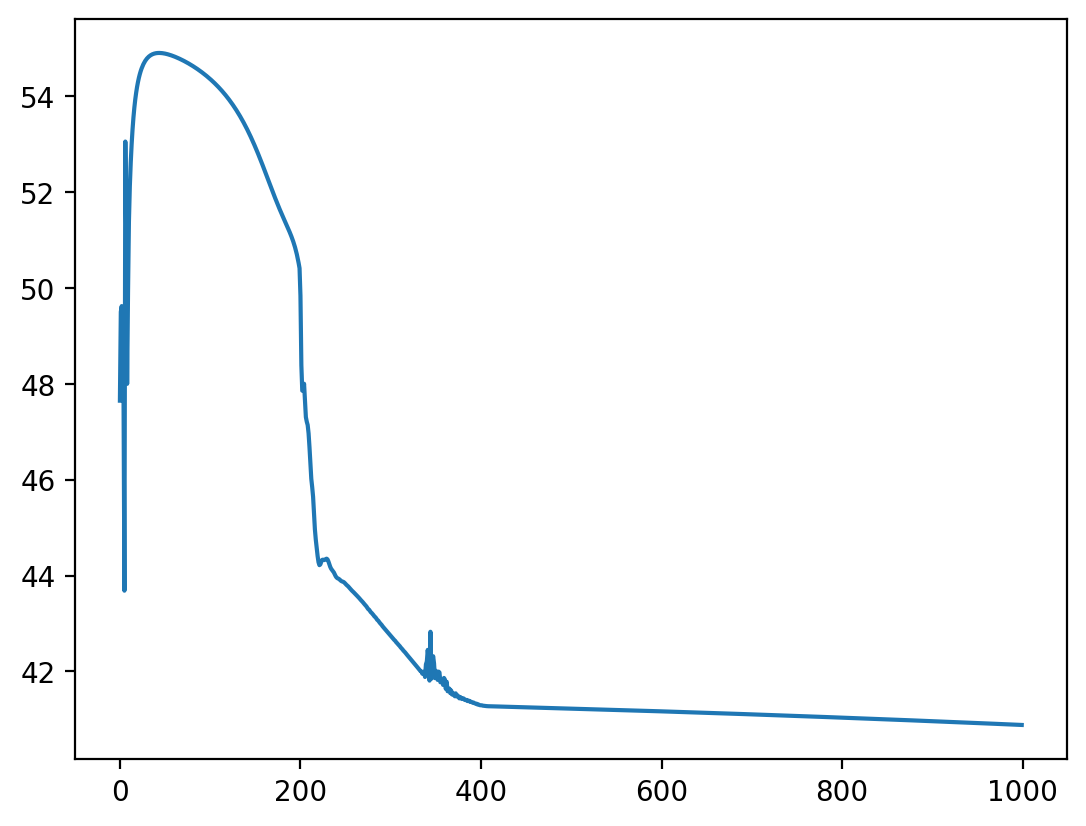

In [20]:
plt.plot(losses)

In [21]:
x, _ = env.reset()
state = remake_state(x)
key, subkey = jr.split(key)
# Generate an initial (random) action
u = env.action_space.sample()
# initialize some particles
timesteps=jnp.arange(control_horizon)
samp = model.get_samples(key, jnp.array([state]), jnp.array([u]), num_particles)
all_samples = [samp]
for t in timesteps:
    aa = jax.vmap(control_policy)(samp, jnp.tile(timestep, num_particles))
    key, subkey = jr.split(key)
    samp = model.get_samples(key, samp, aa, 1)
    all_samples.append(samp)
    cost = jnp.mean(jax.vmap(cart_pole_cost)(jnp.hstack((samp, aa))))
    #print(t,cost)
all_samples = jnp.array(all_samples)

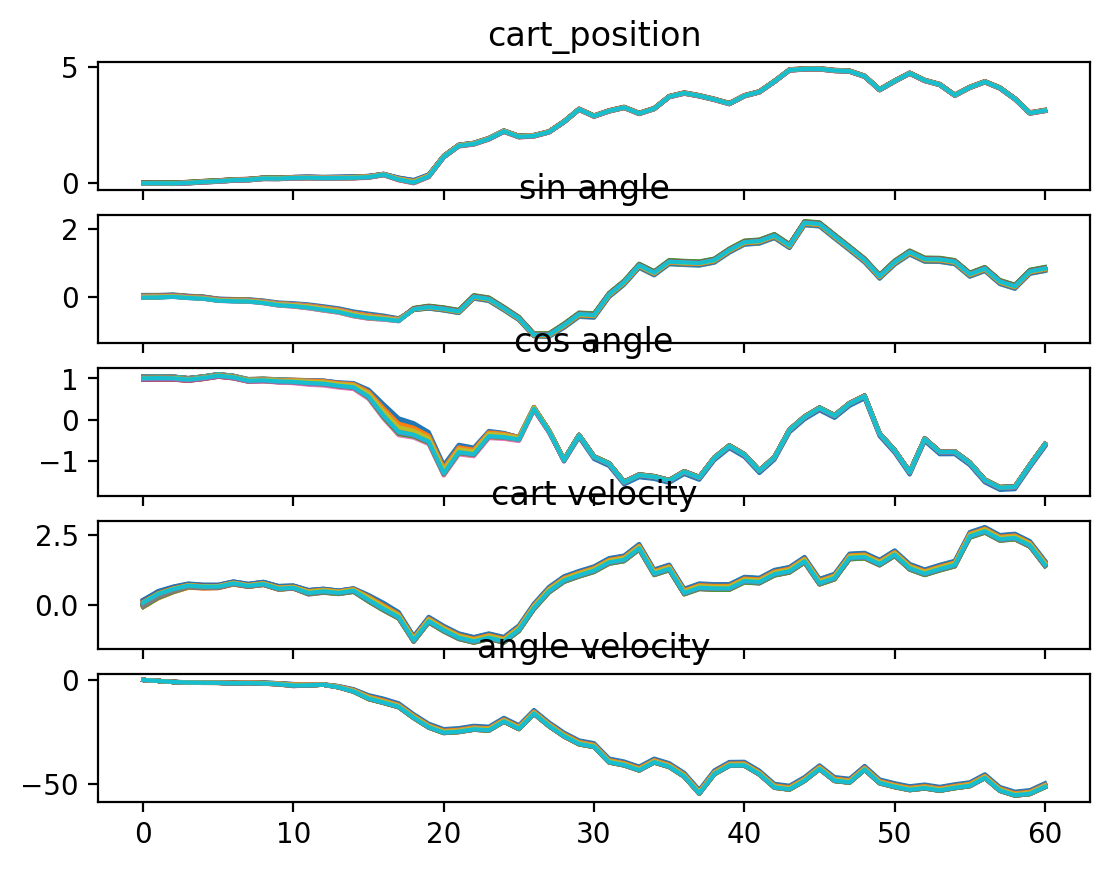

In [22]:
titles = ['cart_position','sin angle','cos angle', 'cart velocity','angle velocity']
fig, ax = plt.subplots(state_dim,1,sharex=True)
for i in range(state_dim):
    for particle in range(100):
        ax[i].plot(all_samples[:,particle,i])
    ax[i].set_title(titles[i]);
plt.show()

[ 0.00073175 -0.00216941  0.21412313 -0.45889624]
[ 0.01415561 -0.03130485  0.45676171 -0.99600377]
[ 0.03561303 -0.07805486  0.61633786 -1.34541993]
[ 0.06146093 -0.13467513  0.6767434  -1.49416323]
[ 0.08909051 -0.19664822  0.70551085 -1.61432026]
[ 0.1176534  -0.26390703  0.72335551 -1.75873041]
[ 0.14687523 -0.33784388  0.73830386 -1.94814635]
[ 0.17674766 -0.42053513  0.75560085 -2.19606264]
[ 0.20742337 -0.51447455  0.77800215 -2.50979306]
[ 0.23906337 -0.62222434  0.80314281 -2.8854993 ]
[ 0.2716117  -0.74596726  0.82256886 -3.30831422]
[ 0.30464171 -0.88729313  0.82625133 -3.76368732]
[ 0.33738555 -1.04738353  0.80719691 -4.2458129 ]
[ 0.36883672 -1.22729228  0.76055078 -4.75423159]
[ 0.39779498 -1.42808124  0.68165001 -5.28991241]
[ 0.42311381 -1.61987917  0.5993198  -2.2269765 ]
[ 0.44889943 -1.64060133  0.68850962  0.41596721]
[ 0.47504285 -1.61670001  0.61756827  0.6174354 ]
[ 0.49846614 -1.59609864  0.55379689  0.40023958]
[ 0.51906058 -1.58413766  0.47609097  0.21109473]


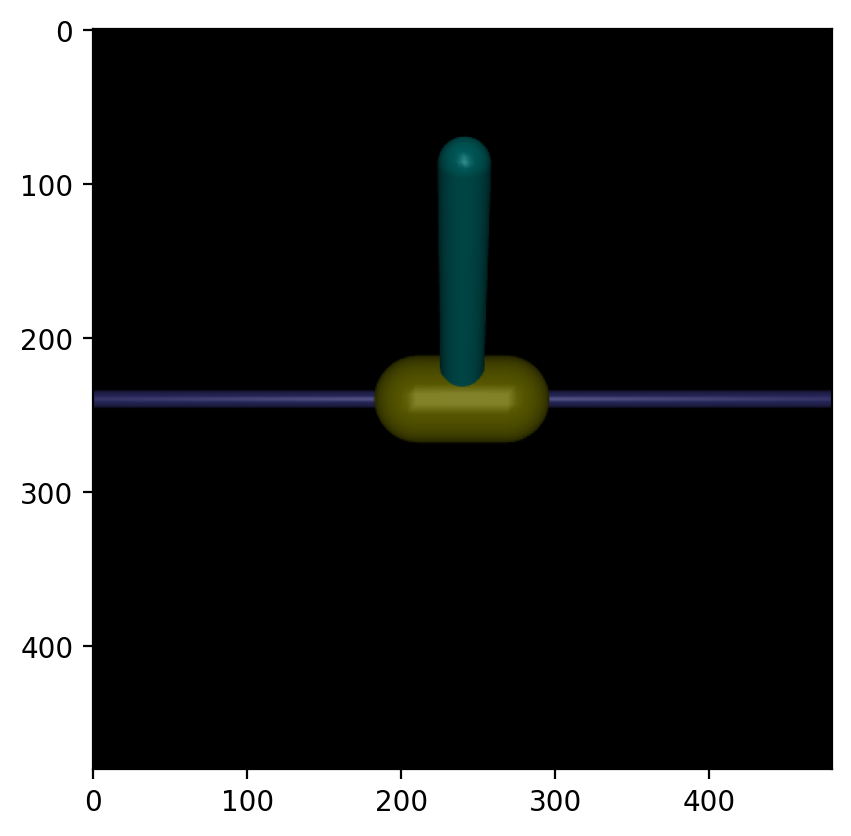

In [23]:
# Now try this policy on the real system
x, _ = env_test.reset()
state = remake_state(x)
key, subkey = jr.split(key)
u = control_policy(state,timestep)
# Randomly sample some points
states.append(state)
actions.append(u)
#img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    state = remake_state(x)
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(state,timestep)
    states.append(state)
    actions.append(u)
    print(x)
    # img.set_data(env_test.render()) # just update the data
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

In [24]:
%%time
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

61.2374225525204
-228.57297193654475
CPU times: user 13.5 s, sys: 3.4 s, total: 16.9 s
Wall time: 6.02 s


## Visualize how well the model is predicting the next state

In [25]:
# st = jnp.array(states)
# pm = model.predict_all_outputs(jnp.hstack((st,jnp.array(actions))))
# titles = ['cart_position','angle','cart velocity','angle velocity']
# fig, ax = plt.subplots(4,1,sharex=True)
# for i in range(4):
#     ax[i].plot(pm[:-1,i,0],color='red',label='mu',marker='s')
#     ax[i].plot(st[1:,i],color='blue',label='true',marker='.')
#     ax[i].legend();
#     ax[i].set_title(titles[i]);

In [26]:
optimizer = ox.inject_hyperparams(ox.adam)(learning_rate=1e-2)

In [27]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    starting_dropout_probability=starting_dropout_probability,
    env=env,
    num_particles=num_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    obj_func=cart_pole_cost,
    optim=optimizer,
    num_iters=1000
)

step=0, train_loss=50.05715104778765, 
step=50, train_loss=14.080803086819301, 
step=100, train_loss=12.652033399790959, 
step=150, train_loss=11.73562014670035, 
Decreasing dropout probability at step=199,
Decreasing dropout probability at step=200,
step=200, train_loss=13.021234384009055, 
Decreasing dropout probability at step=201,
Decreasing dropout probability at step=202,
Decreasing dropout probability at step=203,
Decreasing dropout probability at step=204,
step=250, train_loss=12.038886875808606, 
step=300, train_loss=11.753098948729432, 
Decreasing dropout probability at step=308,
step=350, train_loss=11.611159875463418, 
step=400, train_loss=11.519649076852975, 
step=450, train_loss=11.456594162397582, 
step=500, train_loss=11.411552213337211, 
step=550, train_loss=11.375869850436365, 
step=600, train_loss=11.344745941079504, 
step=650, train_loss=11.316115673996828, 
step=700, train_loss=11.289168398354887, 
step=750, train_loss=11.263540276419286, 
step=800, train_loss=11.2

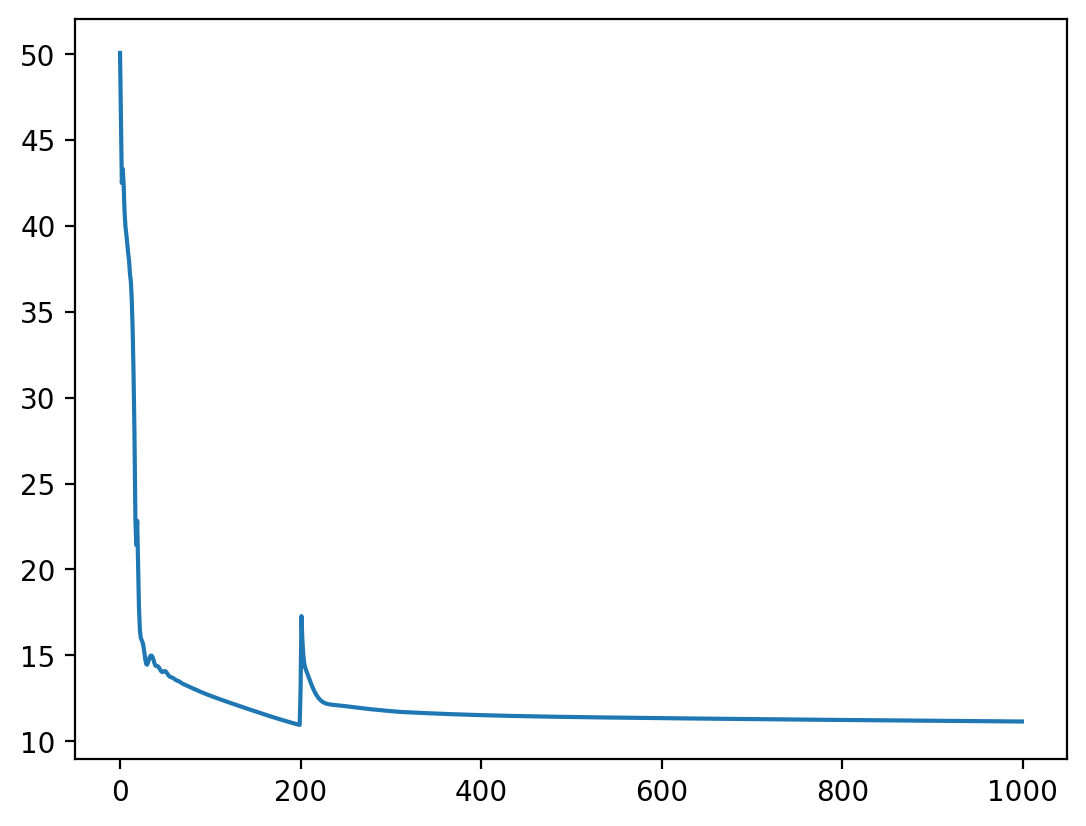

In [28]:
plt.plot(losses)

[ 0.00874472 -0.01493052  0.2532383  -0.59867043]
[ 0.01495285 -0.0294728   0.05817175 -0.13785269]
[ 0.01865393 -0.03852776  0.12678324 -0.31421192]
[ 0.02191269 -0.04727178  0.03662431 -0.12738919]
[ 0.02371218 -0.05384006  0.05336877 -0.20130637]
[ 0.02465638 -0.05989362 -0.00587889 -0.1039775 ]
[ 0.0242671  -0.06464985 -0.01352935 -0.13437862]
[ 0.02280316 -0.06890667 -0.05948781 -0.08010699]
[ 0.02001452 -0.0723072  -0.07988106 -0.09048325]
[ 0.0160146  -0.07526302 -0.11999308 -0.05838372]
[ 0.01066562 -0.07760861 -0.14739639 -0.05938541]
[ 0.00401447 -0.0795614  -0.18507538 -0.0389682 ]
[-0.00401729 -0.08104452 -0.21646222 -0.03557024]
[-0.01341249 -0.08217345 -0.25323696 -0.02134137]
[-0.024216   -0.08291208 -0.28689826 -0.01585558]
[-0.03642198 -0.08332116 -0.32335814 -0.00487528]
[-0.0500544  -0.08338283 -0.35823387  0.00164651]
[-0.06510927 -0.08312804 -0.3944823   0.01097127]
[-0.08159581 -0.08254685 -0.42982677  0.01806237]
[-0.09950673 -0.08165399 -0.46570574  0.02659746]


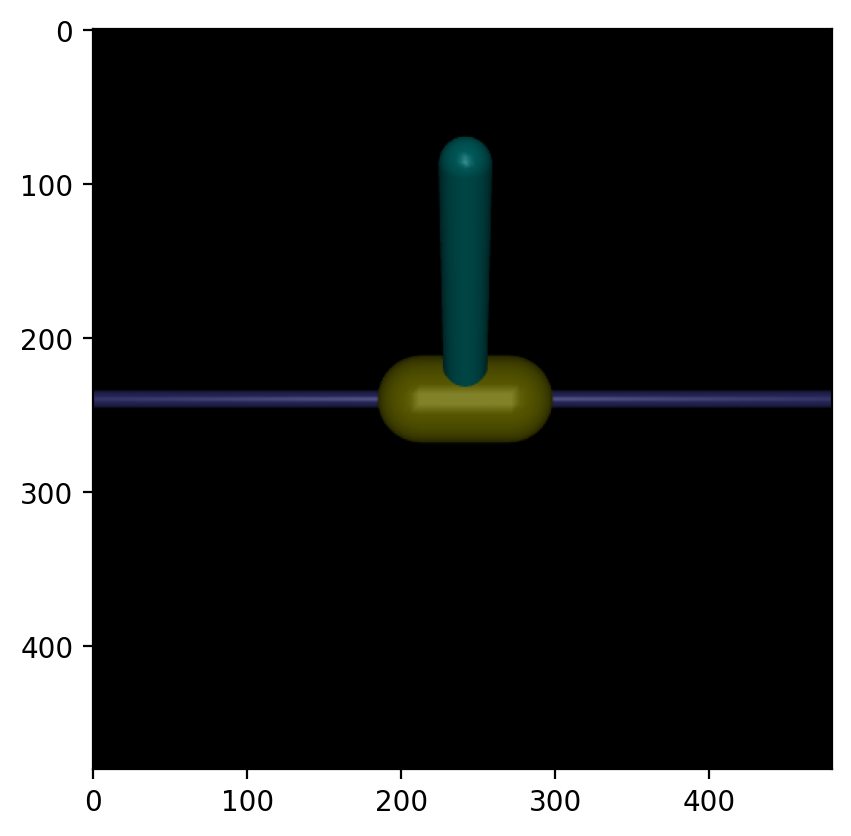

In [29]:
# Now try this policy on the real system
x, _ = env_test.reset()
state = remake_state(x)
key, subkey = jr.split(key)
u = control_policy(state,timestep)
# Randomly sample some points
states.append(state)
actions.append(u)
#img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    state = remake_state(x)
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(state,timestep)
    states.append(state)
    actions.append(u)
    print(x)
    # img.set_data(env_test.render()) # just update the data
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

In [30]:
len(states)

370

In [31]:
%%time
model = MGPR(states=jnp.array(states),actions=jnp.array(actions))
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))
model.optimize()
print(-model.build_gp(model.models[0]).log_probability(model.training_outputs[:,0]))

16.314091730940504
-270.1796530789541
CPU times: user 15.2 s, sys: 2.15 s, total: 17.3 s
Wall time: 5.91 s


In [32]:
optimizer = ox.inject_hyperparams(ox.adam)(learning_rate=1e-2)

In [33]:
%%time
control_policy, losses = fit_controller(
    policy=control_policy,
    starting_dropout_probability=starting_dropout_probability,
    env=env,
    num_particles=num_particles,
    timesteps=jnp.arange(control_horizon),
    gp_model=model,
    obj_func=cart_pole_cost,
    optim=optimizer,
    num_iters=1000
)

step=0, train_loss=18.27851585730596, 
step=50, train_loss=6.90365900684409, 
step=100, train_loss=6.520148691019952, 
step=150, train_loss=6.251161302475233, 
Decreasing dropout probability at step=199,
Decreasing dropout probability at step=200,
step=200, train_loss=6.407927401957567, 
Decreasing dropout probability at step=201,
Decreasing dropout probability at step=202,
Decreasing dropout probability at step=203,
Decreasing dropout probability at step=204,
Decreasing dropout probability at step=205,
step=250, train_loss=6.292179482328876, 
step=300, train_loss=6.206067845459319, 
step=350, train_loss=6.157140257453512, 
step=400, train_loss=6.126510986097173, 
step=450, train_loss=6.1043233741312815, 
step=500, train_loss=6.086779655147537, 
step=550, train_loss=6.0723586619217835, 
step=600, train_loss=6.0602254244494524, 
step=650, train_loss=6.049786559065545, 
step=700, train_loss=6.040584709448644, 
step=750, train_loss=6.03226492094746, 
step=800, train_loss=6.02455567497248,

[-0.00128697  0.00258228  0.00841071 -0.03119935]
[-0.00110277  0.00179364  0.00084822 -0.00870258]
[-0.00095988  0.00126516  0.00629175 -0.01769855]
[-0.00075095  0.00072652  0.00417672 -0.00945444]
[-0.00054385  0.00030856  0.00618277 -0.01149664]
[-3.06351394e-04 -8.15203736e-05  5.70441741e-03 -8.13111399e-03]
[-6.23433218e-05 -4.06593096e-04  6.50176314e-03 -8.18549081e-03]
[ 0.0001967  -0.00070074  0.00645822 -0.00660195]
[ 0.00046143 -0.00095559  0.00678337 -0.00619615]
[ 0.00073303 -0.00118507  0.00680243 -0.00533516]
[ 0.00100708 -0.001389    0.00690453 -0.00490785]
[ 0.00128261 -0.00157395  0.00687637 -0.00438364]
[ 0.00155694 -0.00174161  0.00684352 -0.00403747]
[ 0.00182853 -0.00189553  0.00673954 -0.00369389]
[ 0.00209536 -0.00203746  0.00660535 -0.00343421]
[ 0.00235583 -0.00216951  0.00642086 -0.00319797]
[ 0.00260818 -0.00229305  0.00619972 -0.00300663]
[ 0.00285085 -0.00240942  0.00593625 -0.00283755]
[ 0.00308223 -0.00251957  0.00563527 -0.00269441]
[ 0.0033008  -0.00

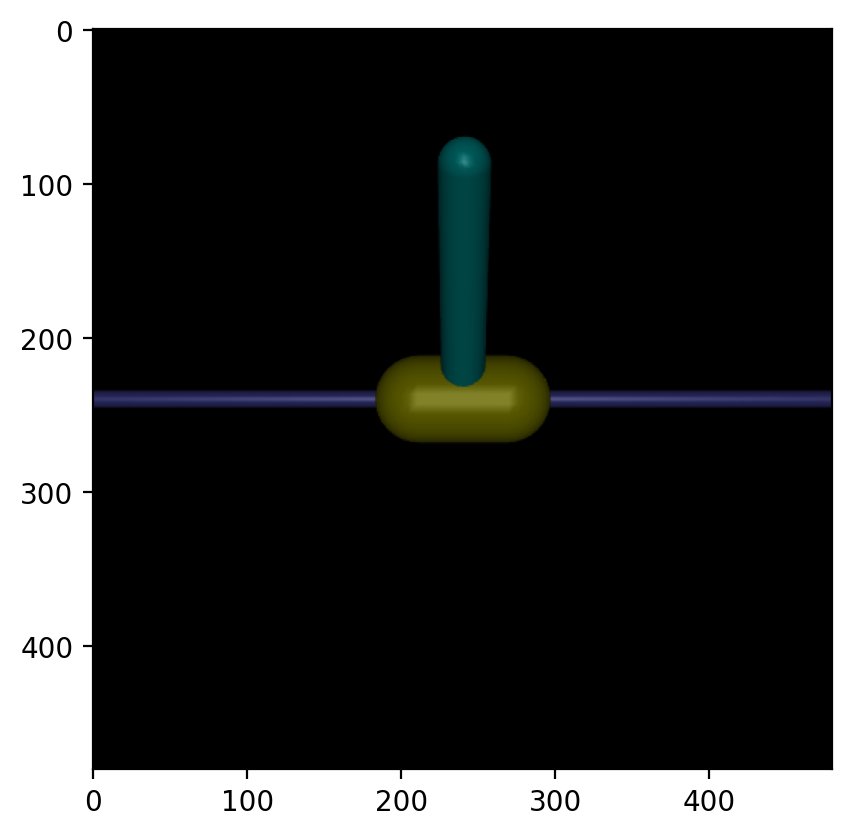

In [34]:
# Now try this policy on the real system
x, _ = env_test.reset()
state = remake_state(x)
key, subkey = jr.split(key)
u = control_policy(state,timestep)
# Randomly sample some points
states.append(state)
actions.append(u)
#img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    state = remake_state(x)
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(state,timestep)
    states.append(state)
    actions.append(u)
    print(x)
    # img.set_data(env_test.render()) # just update the data
    # display.display(plt.gcf())
    # display.clear_output(wait=True)

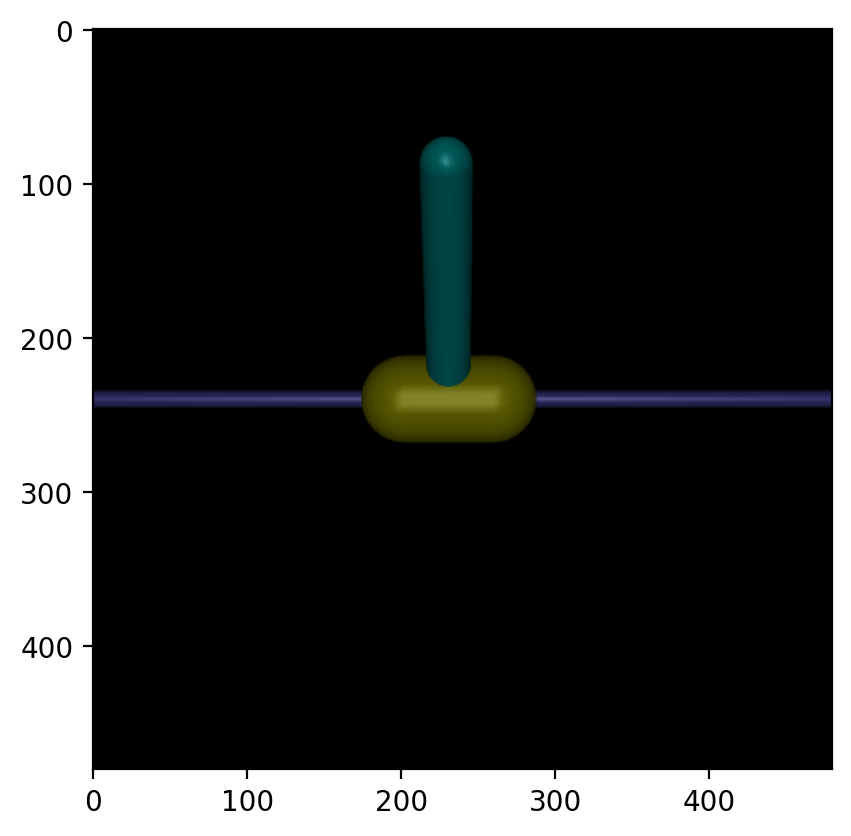

In [38]:
# Now try this policy on the real system
x, _ = env_test.reset()
print(x)
state = remake_state(x)
key, subkey = jr.split(key)
u = control_policy(state,timestep)
# Randomly sample some points
img = plt.imshow(env_test.render()) # only call this once
for timestep in np.linspace(0,T_exploration,int(T_exploration/sim_timestep)+1):
    z = env_test.step(np.array(u))
    x = z[0]
    state = remake_state(x)
    r = z[1]
    key, subkey = jr.split(key)
    u = control_policy(state,timestep)
    img.set_data(env_test.render()) # just update the data
    display.display(plt.gcf())
    display.clear_output(wait=True)

In [39]:
x, _ = env_test.reset()
print(x)

[ 0.00678813  0.00394552 -0.00248562 -0.00397841]
